In [25]:
import pandas as pd
from gqlalchemy import Memgraph
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pickle

import networkx as nx
import tnetwork as tn

from pymongo import MongoClient


In [5]:
def get_mongo_db():
    client = MongoClient("mongodb://localhost:27017")
    db = client["brain"]["calcium_synapses"]
    return db

db = get_mongo_db()


In [14]:
cursor = db.find({}, {"_id": 0, "edge_id": 0})

synapses = {}
for synapse in tqdm(cursor, total=55619871):
    edge = tuple(sorted((synapse["from_id"], synapse["to_id"])))
    synapses[edge] = synapses.get(edge, {"source": synapse["from_id"], "target": synapse["to_id"]}) | {f"t{synapse['step'] // 10000}": synapse["weight"]}

df = pd.DataFrame.from_dict(synapses, orient="index")
df

100%|██████████| 55619871/55619871 [05:37<00:00, 164939.07it/s]


source  target   t0   t1   t2   t3   t4   t5   t6   t7  ...  t91   
12    13         12      13  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  NaN  \
13    282       282      13  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  NaN   
      23         23      13  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  NaN   
      46         46      13  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  NaN   
      1451     1451      13  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0   
...             ...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
47742 49923   47742   49923  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
49437 49957   49437   49957  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
49692 49960   49692   49960  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
47457 49960   47457   49960  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   
334   2549     2549     334  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN   

             t92  t93  t94  t95  t96  t97  t98  t99  t100  
12    13     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  
13    282    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  
      23     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  
      46     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  
      1451   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   1.0  
...          ...  ...  ...  ...  ...  ...  ...  ...   ...  
47742 49923  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1.0  
49437 49957  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1.0  
49692 49960  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1.0  
47457 49960  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1.0  
334   2549   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   1.0  

[1172947 rows x 103 columns]

In [26]:
def get_graph_for_timestep(df, timestep: int):
    graph = nx.DiGraph()
    # 5k instead of 50k because we only care about the blobs
    graph.add_nodes_from(range(5_000))

    blob_edges: dict[tuple[int, int], int] = {}

    df = df[["source", "target", f"t{timestep}"]].copy()
    df.rename(columns={f"t{timestep}": "weight"}, inplace=True)
    for _, row in df.iterrows():
        edge = tuple(sorted((row.source // 10, row.target // 10)))
        blob_edges[edge] = blob_edges.get(edge, 0) + row.weight

    

    for (source, target), weight in blob_edges.items():
        graph.add_edge(source, target, weight=weight)

    return graph

G = tn.DynGraphSN()
timesteps = 101
for t in tqdm(range(0, timesteps)):

    nxG = get_graph_for_timestep(df, t)
    G.add_snapshot(t, nxG)

with open("dynamic_graph.pickle", "r") as file:
    G = pickle.load(file)



UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 61: character maps to <undefined>

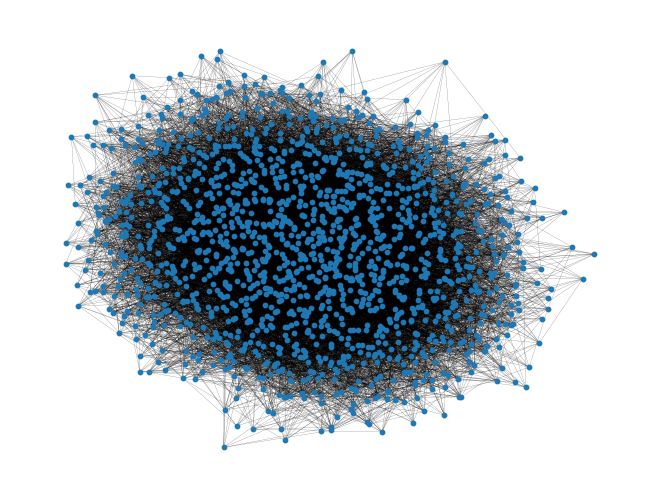

In [5]:
plt.close("all")
snapshot0 = G.snapshots(0)
pos = nx.spring_layout(snapshot0)
nx.draw(snapshot0, pos=pos, node_size=10, width=0.1)

In [13]:
partition = tn.DCD.rollingCPM(G)


CD detection done 101


/home/theo/.local/share/virtualenvs/dis-gRFrr5sP/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


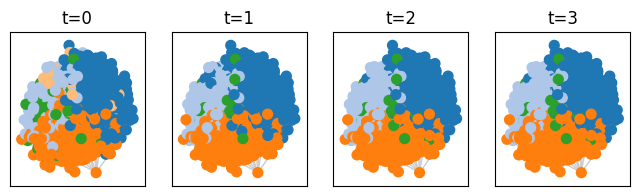

In [11]:
partition
times_to_plot = list(range(4))
plot = tn.plot_as_graph(G,partition,ts=times_to_plot,auto_show=True,width=200,height=200)

In [8]:
# 20 random nodes



/home/theo/.local/share/virtualenvs/dis-gRFrr5sP/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


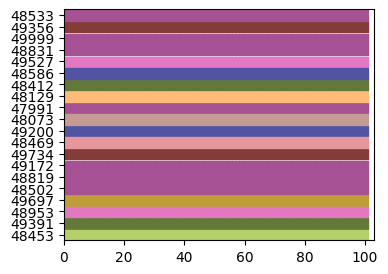

In [17]:
random_nodes = list(np.random.choice(list(G.node_presence().keys()), 20))

plot = tn.plot_longitudinal(G,communities=partition,auto_show=True,width=400,height=300, nodes=random_nodes)
